# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

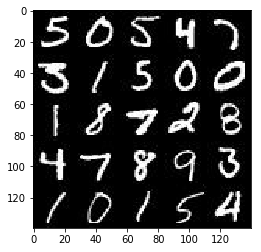

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

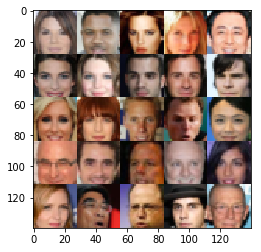

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="intput_images")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    #print(images)
    alpha = .2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        first_layer = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        first_layer = tf.maximum(first_layer * alpha, first_layer)
        
        second_layer = tf.layers.conv2d(first_layer, 128, 5, strides=2, padding='same')
        second_layer = tf.layers.batch_normalization(second_layer, training=True)
        second_layer = tf.maximum(second_layer * alpha, second_layer)
        
        third_layer = tf.layers.conv2d(second_layer, 256, 5, strides=2, padding='same')
        third_layer = tf.layers.batch_normalization(third_layer, training=True)
        third_layer = tf.maximum(third_layer * alpha, third_layer)
        
        flattened = tf.reshape(third_layer, (-1, 4*4*256))
        logits = tf.layers.dense(flattened, 1)
        
        output = tf.sigmoid(logits)
                                                
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = .2
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        first_layer = tf.layers.dense(z, 4*4*512)
        first_layer = tf.reshape(first_layer, (-1, 2, 2, 512))
        first_layer = tf.layers.batch_normalization(first_layer, training=is_train)
        #print(first_layer.shape)
        
        second_layer = tf.layers.conv2d_transpose(first_layer, 256, 5, strides=2, padding='same')
        second_layer = tf.layers.batch_normalization(second_layer, training=is_train)
        second_layer = tf.maximum(second_layer * alpha, second_layer)
        #print(second_layer.shape)
        
        third_layer = tf.layers.conv2d_transpose(second_layer, 128, 5, strides=3, padding='valid')
        third_layer = tf.layers.batch_normalization(third_layer, training=is_train)
        third_layer = tf.maximum(third_layer * alpha, third_layer)
        #print(third_layer.shape)
        
        logits = tf.layers.conv2d_transpose(third_layer, out_channel_dim, 5, strides=2, padding='same')
        #print(logits.shape)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False) 
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    #print(input_real)
    #print(g_model)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    #print('epoch_count={}'.format(epoch_count))
    #print('batch_size={}'.format(batch_size))
    #print('z_dim={}'.format(z_dim))
    #print('learning_rate={}'.format(learning_rate))
    #print('beta1={}'.format(beta1))
    #print(get_batches)
    #print('data_shape={}'.format(data_shape))
    #print('data_image_mode={}'.format(data_image_mode))
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                
                
                if steps % 10 == 0:
                    # Get the losses and print them out after 10 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 5, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0686... Generator Loss: 3.2060
Epoch 1/2... Discriminator Loss: 0.0435... Generator Loss: 4.5601
Epoch 1/2... Discriminator Loss: 0.5112... Generator Loss: 8.8034
Epoch 1/2... Discriminator Loss: 0.1342... Generator Loss: 4.7195
Epoch 1/2... Discriminator Loss: 0.2130... Generator Loss: 2.3642
Epoch 1/2... Discriminator Loss: 0.1540... Generator Loss: 4.0557
Epoch 1/2... Discriminator Loss: 0.3784... Generator Loss: 3.8152
Epoch 1/2... Discriminator Loss: 0.6194... Generator Loss: 2.3053
Epoch 1/2... Discriminator Loss: 1.0722... Generator Loss: 0.6680
Epoch 1/2... Discriminator Loss: 0.6195... Generator Loss: 1.3227


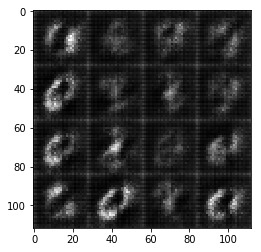

Epoch 1/2... Discriminator Loss: 0.9491... Generator Loss: 0.7361
Epoch 1/2... Discriminator Loss: 0.4354... Generator Loss: 1.9778
Epoch 1/2... Discriminator Loss: 0.4323... Generator Loss: 1.6591
Epoch 1/2... Discriminator Loss: 0.2743... Generator Loss: 2.1856
Epoch 1/2... Discriminator Loss: 0.6049... Generator Loss: 6.2917
Epoch 1/2... Discriminator Loss: 0.2192... Generator Loss: 2.0915
Epoch 1/2... Discriminator Loss: 0.1570... Generator Loss: 2.7462
Epoch 1/2... Discriminator Loss: 0.1379... Generator Loss: 2.9728
Epoch 1/2... Discriminator Loss: 0.1495... Generator Loss: 2.4992
Epoch 1/2... Discriminator Loss: 0.2025... Generator Loss: 2.4021


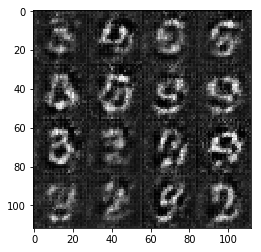

Epoch 1/2... Discriminator Loss: 0.1770... Generator Loss: 3.5192
Epoch 1/2... Discriminator Loss: 0.2003... Generator Loss: 2.0147
Epoch 1/2... Discriminator Loss: 1.3556... Generator Loss: 2.9498
Epoch 1/2... Discriminator Loss: 1.1921... Generator Loss: 0.5538
Epoch 1/2... Discriminator Loss: 2.0604... Generator Loss: 0.2022
Epoch 1/2... Discriminator Loss: 0.3118... Generator Loss: 1.9253
Epoch 1/2... Discriminator Loss: 0.5425... Generator Loss: 1.1365
Epoch 1/2... Discriminator Loss: 0.2435... Generator Loss: 3.3118
Epoch 1/2... Discriminator Loss: 0.2772... Generator Loss: 3.2183
Epoch 1/2... Discriminator Loss: 0.2736... Generator Loss: 2.3428


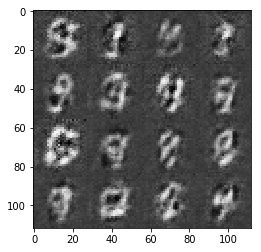

Epoch 1/2... Discriminator Loss: 0.7909... Generator Loss: 0.8768
Epoch 1/2... Discriminator Loss: 0.1391... Generator Loss: 3.9339
Epoch 1/2... Discriminator Loss: 0.1125... Generator Loss: 3.0756
Epoch 1/2... Discriminator Loss: 0.1686... Generator Loss: 3.3954
Epoch 1/2... Discriminator Loss: 0.1808... Generator Loss: 3.6431
Epoch 1/2... Discriminator Loss: 0.2114... Generator Loss: 4.0715
Epoch 1/2... Discriminator Loss: 0.1151... Generator Loss: 3.2828
Epoch 1/2... Discriminator Loss: 0.1360... Generator Loss: 4.7320
Epoch 1/2... Discriminator Loss: 0.3917... Generator Loss: 1.4286
Epoch 1/2... Discriminator Loss: 0.1954... Generator Loss: 2.5935


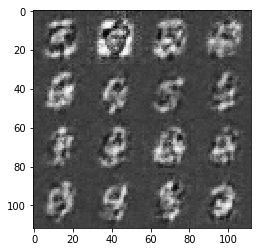

Epoch 1/2... Discriminator Loss: 0.3062... Generator Loss: 1.7005
Epoch 1/2... Discriminator Loss: 0.2000... Generator Loss: 2.3264
Epoch 1/2... Discriminator Loss: 0.2041... Generator Loss: 2.1744
Epoch 1/2... Discriminator Loss: 0.2722... Generator Loss: 1.8838
Epoch 1/2... Discriminator Loss: 2.2315... Generator Loss: 0.1797
Epoch 1/2... Discriminator Loss: 0.2050... Generator Loss: 3.0357
Epoch 2/2... Discriminator Loss: 0.2866... Generator Loss: 1.8399
Epoch 2/2... Discriminator Loss: 0.1828... Generator Loss: 2.3524
Epoch 2/2... Discriminator Loss: 0.1786... Generator Loss: 2.5381
Epoch 2/2... Discriminator Loss: 0.1702... Generator Loss: 2.3924


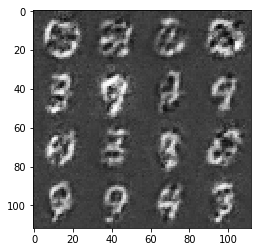

Epoch 2/2... Discriminator Loss: 0.1832... Generator Loss: 2.6820
Epoch 2/2... Discriminator Loss: 0.4588... Generator Loss: 1.2361
Epoch 2/2... Discriminator Loss: 2.1912... Generator Loss: 0.1815
Epoch 2/2... Discriminator Loss: 0.3560... Generator Loss: 2.0563
Epoch 2/2... Discriminator Loss: 0.1912... Generator Loss: 2.2663
Epoch 2/2... Discriminator Loss: 0.1957... Generator Loss: 2.2736
Epoch 2/2... Discriminator Loss: 0.1453... Generator Loss: 2.8531
Epoch 2/2... Discriminator Loss: 0.2026... Generator Loss: 2.1678
Epoch 2/2... Discriminator Loss: 0.1704... Generator Loss: 2.4182
Epoch 2/2... Discriminator Loss: 0.1502... Generator Loss: 2.6056


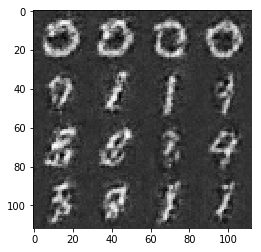

Epoch 2/2... Discriminator Loss: 2.2505... Generator Loss: 7.0087
Epoch 2/2... Discriminator Loss: 0.4949... Generator Loss: 1.6930
Epoch 2/2... Discriminator Loss: 0.3591... Generator Loss: 1.8915
Epoch 2/2... Discriminator Loss: 0.2653... Generator Loss: 1.9237
Epoch 2/2... Discriminator Loss: 0.3458... Generator Loss: 1.8452
Epoch 2/2... Discriminator Loss: 0.1891... Generator Loss: 2.3166
Epoch 2/2... Discriminator Loss: 0.1982... Generator Loss: 2.1736
Epoch 2/2... Discriminator Loss: 0.2229... Generator Loss: 2.1072
Epoch 2/2... Discriminator Loss: 0.1838... Generator Loss: 2.4707
Epoch 2/2... Discriminator Loss: 4.7433... Generator Loss: 8.0836


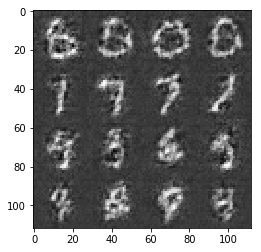

Epoch 2/2... Discriminator Loss: 0.3011... Generator Loss: 2.2270
Epoch 2/2... Discriminator Loss: 0.3114... Generator Loss: 1.9423
Epoch 2/2... Discriminator Loss: 0.2479... Generator Loss: 2.1792
Epoch 2/2... Discriminator Loss: 0.1924... Generator Loss: 2.3624
Epoch 2/2... Discriminator Loss: 0.2586... Generator Loss: 1.9687
Epoch 2/2... Discriminator Loss: 0.2601... Generator Loss: 1.9900
Epoch 2/2... Discriminator Loss: 0.2059... Generator Loss: 2.2543
Epoch 2/2... Discriminator Loss: 0.1220... Generator Loss: 2.8927
Epoch 2/2... Discriminator Loss: 0.2300... Generator Loss: 1.8401
Epoch 2/2... Discriminator Loss: 1.8510... Generator Loss: 0.3724


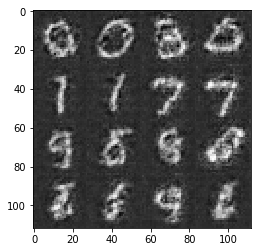

Epoch 2/2... Discriminator Loss: 0.2075... Generator Loss: 2.7356
Epoch 2/2... Discriminator Loss: 0.2720... Generator Loss: 2.1832
Epoch 2/2... Discriminator Loss: 0.2465... Generator Loss: 2.1462
Epoch 2/2... Discriminator Loss: 0.1550... Generator Loss: 2.7486
Epoch 2/2... Discriminator Loss: 0.1467... Generator Loss: 2.7447
Epoch 2/2... Discriminator Loss: 0.1175... Generator Loss: 2.9574
Epoch 2/2... Discriminator Loss: 0.1309... Generator Loss: 2.8253
Epoch 2/2... Discriminator Loss: 0.1475... Generator Loss: 3.4066
Epoch 2/2... Discriminator Loss: 0.1224... Generator Loss: 2.9912
Epoch 2/2... Discriminator Loss: 3.4967... Generator Loss: 4.5770


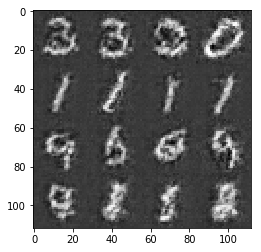

Epoch 2/2... Discriminator Loss: 0.3185... Generator Loss: 2.2441
Epoch 2/2... Discriminator Loss: 0.1818... Generator Loss: 3.0082
Epoch 2/2... Discriminator Loss: 0.1182... Generator Loss: 3.0112


In [12]:
batch_size = 128
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3369... Generator Loss: 2.2697
Epoch 1/1... Discriminator Loss: 0.1174... Generator Loss: 3.8449
Epoch 1/1... Discriminator Loss: 0.1065... Generator Loss: 3.7185
Epoch 1/1... Discriminator Loss: 0.0807... Generator Loss: 4.1123
Epoch 1/1... Discriminator Loss: 0.2737... Generator Loss: 1.9173
Epoch 1/1... Discriminator Loss: 0.0328... Generator Loss: 6.7262
Epoch 1/1... Discriminator Loss: 0.5625... Generator Loss: 1.2701
Epoch 1/1... Discriminator Loss: 0.1035... Generator Loss: 6.3508
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 1.3895
Epoch 1/1... Discriminator Loss: 0.2767... Generator Loss: 2.0339


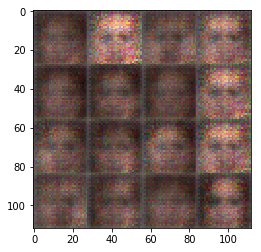

Epoch 1/1... Discriminator Loss: 0.1103... Generator Loss: 3.6904
Epoch 1/1... Discriminator Loss: 0.1564... Generator Loss: 2.4270
Epoch 1/1... Discriminator Loss: 0.0579... Generator Loss: 3.4760
Epoch 1/1... Discriminator Loss: 0.1356... Generator Loss: 2.6546
Epoch 1/1... Discriminator Loss: 0.3091... Generator Loss: 4.8463
Epoch 1/1... Discriminator Loss: 0.1114... Generator Loss: 3.5572
Epoch 1/1... Discriminator Loss: 0.2644... Generator Loss: 2.3213
Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 4.0975
Epoch 1/1... Discriminator Loss: 1.8832... Generator Loss: 0.3440
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 0.9484


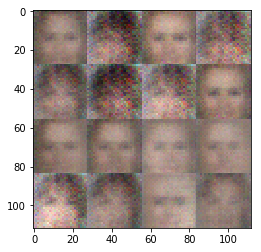

Epoch 1/1... Discriminator Loss: 0.3985... Generator Loss: 3.4138
Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 2.7629
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 2.5172
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 1.5764
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 0.8632... Generator Loss: 1.1110
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 1.3940
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 1.9349


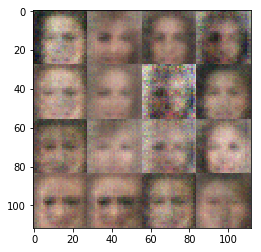

Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.2963
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 1.5068
Epoch 1/1... Discriminator Loss: 1.8297... Generator Loss: 0.2450
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.3276
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 0.6212... Generator Loss: 2.4512
Epoch 1/1... Discriminator Loss: 0.5050... Generator Loss: 1.1791
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.3984
Epoch 1/1... Discriminator Loss: 0.5952... Generator Loss: 1.0387


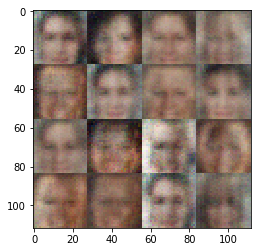

Epoch 1/1... Discriminator Loss: 0.1673... Generator Loss: 3.0099
Epoch 1/1... Discriminator Loss: 0.6534... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.8676... Generator Loss: 0.3318
Epoch 1/1... Discriminator Loss: 0.1450... Generator Loss: 2.8689
Epoch 1/1... Discriminator Loss: 0.1952... Generator Loss: 3.8672
Epoch 1/1... Discriminator Loss: 0.4455... Generator Loss: 1.4419
Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 4.2639
Epoch 1/1... Discriminator Loss: 0.7308... Generator Loss: 2.4863
Epoch 1/1... Discriminator Loss: 0.2794... Generator Loss: 5.0345


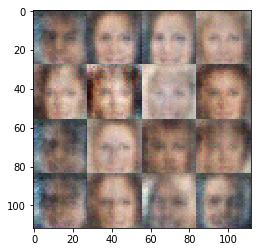

Epoch 1/1... Discriminator Loss: 0.6727... Generator Loss: 3.2025
Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 2.7833
Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 6.6203
Epoch 1/1... Discriminator Loss: 0.2821... Generator Loss: 5.2094
Epoch 1/1... Discriminator Loss: 0.3303... Generator Loss: 3.2312
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 0.2724... Generator Loss: 2.9780
Epoch 1/1... Discriminator Loss: 0.4870... Generator Loss: 8.5638
Epoch 1/1... Discriminator Loss: 0.5639... Generator Loss: 1.1415
Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 1.0917


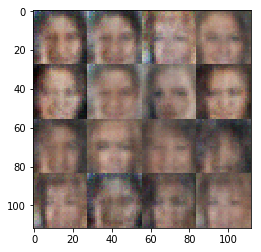

Epoch 1/1... Discriminator Loss: 0.1439... Generator Loss: 6.9106
Epoch 1/1... Discriminator Loss: 0.1374... Generator Loss: 5.3898
Epoch 1/1... Discriminator Loss: 2.4891... Generator Loss: 3.1963
Epoch 1/1... Discriminator Loss: 0.5694... Generator Loss: 6.2075
Epoch 1/1... Discriminator Loss: 0.2628... Generator Loss: 4.2239
Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 5.2526
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 3.1292
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.4615
Epoch 1/1... Discriminator Loss: 0.1166... Generator Loss: 4.7020
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 1.0041


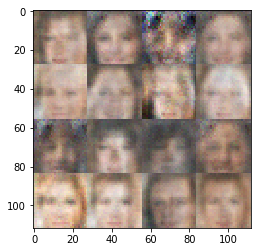

Epoch 1/1... Discriminator Loss: 0.3892... Generator Loss: 1.4372
Epoch 1/1... Discriminator Loss: 0.4550... Generator Loss: 2.0676
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 0.3335... Generator Loss: 1.6288
Epoch 1/1... Discriminator Loss: 0.1375... Generator Loss: 3.0062
Epoch 1/1... Discriminator Loss: 2.5149... Generator Loss: 4.3266
Epoch 1/1... Discriminator Loss: 0.2889... Generator Loss: 2.2918
Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 3.4022
Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 7.2708
Epoch 1/1... Discriminator Loss: 0.3277... Generator Loss: 4.5261


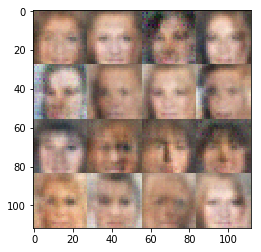

Epoch 1/1... Discriminator Loss: 0.5326... Generator Loss: 1.1706
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 4.4867
Epoch 1/1... Discriminator Loss: 0.2465... Generator Loss: 1.9326
Epoch 1/1... Discriminator Loss: 1.6782... Generator Loss: 0.2423
Epoch 1/1... Discriminator Loss: 0.2639... Generator Loss: 3.8629
Epoch 1/1... Discriminator Loss: 0.6602... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 0.2097... Generator Loss: 3.4754
Epoch 1/1... Discriminator Loss: 0.2807... Generator Loss: 2.4339
Epoch 1/1... Discriminator Loss: 0.1364... Generator Loss: 3.8235
Epoch 1/1... Discriminator Loss: 0.5175... Generator Loss: 1.2069


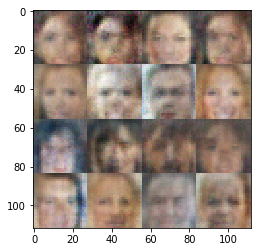

Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 1.5950
Epoch 1/1... Discriminator Loss: 0.0983... Generator Loss: 4.5556
Epoch 1/1... Discriminator Loss: 0.2008... Generator Loss: 2.8793
Epoch 1/1... Discriminator Loss: 0.8101... Generator Loss: 6.7651
Epoch 1/1... Discriminator Loss: 0.6990... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 0.1571... Generator Loss: 2.7137
Epoch 1/1... Discriminator Loss: 0.7050... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 0.3491... Generator Loss: 1.6592
Epoch 1/1... Discriminator Loss: 0.1368... Generator Loss: 3.3462
Epoch 1/1... Discriminator Loss: 0.1639... Generator Loss: 4.8562


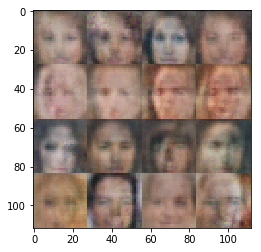

Epoch 1/1... Discriminator Loss: 0.4015... Generator Loss: 2.0219
Epoch 1/1... Discriminator Loss: 0.1677... Generator Loss: 3.3670
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 5.3726
Epoch 1/1... Discriminator Loss: 0.2458... Generator Loss: 3.2869
Epoch 1/1... Discriminator Loss: 0.1135... Generator Loss: 3.5089
Epoch 1/1... Discriminator Loss: 0.3765... Generator Loss: 1.4756
Epoch 1/1... Discriminator Loss: 0.0768... Generator Loss: 3.7351
Epoch 1/1... Discriminator Loss: 0.2836... Generator Loss: 1.7320
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 1.2697
Epoch 1/1... Discriminator Loss: 0.7235... Generator Loss: 0.8548


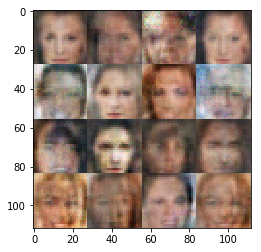

Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 0.1626... Generator Loss: 3.4007
Epoch 1/1... Discriminator Loss: 0.2296... Generator Loss: 2.3897
Epoch 1/1... Discriminator Loss: 0.3154... Generator Loss: 1.6096
Epoch 1/1... Discriminator Loss: 0.3513... Generator Loss: 1.8010
Epoch 1/1... Discriminator Loss: 0.1251... Generator Loss: 2.8379
Epoch 1/1... Discriminator Loss: 0.3389... Generator Loss: 5.0030
Epoch 1/1... Discriminator Loss: 0.5172... Generator Loss: 4.1750
Epoch 1/1... Discriminator Loss: 0.3169... Generator Loss: 6.0891
Epoch 1/1... Discriminator Loss: 0.3370... Generator Loss: 2.1169


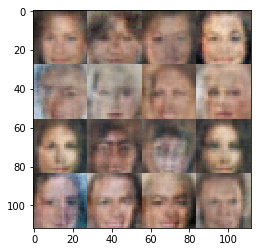

Epoch 1/1... Discriminator Loss: 0.0745... Generator Loss: 4.9322
Epoch 1/1... Discriminator Loss: 0.2586... Generator Loss: 2.7651
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.3392
Epoch 1/1... Discriminator Loss: 0.1559... Generator Loss: 3.5703
Epoch 1/1... Discriminator Loss: 0.3904... Generator Loss: 1.5872
Epoch 1/1... Discriminator Loss: 0.0786... Generator Loss: 4.3919
Epoch 1/1... Discriminator Loss: 0.1600... Generator Loss: 4.5909
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 1.1488
Epoch 1/1... Discriminator Loss: 0.0796... Generator Loss: 6.1720
Epoch 1/1... Discriminator Loss: 0.2089... Generator Loss: 7.9142


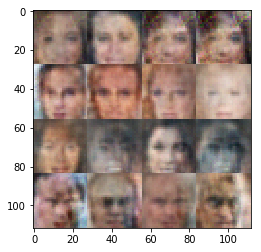

Epoch 1/1... Discriminator Loss: 0.2130... Generator Loss: 2.8739
Epoch 1/1... Discriminator Loss: 0.5889... Generator Loss: 1.1763
Epoch 1/1... Discriminator Loss: 0.1667... Generator Loss: 2.4549
Epoch 1/1... Discriminator Loss: 0.1654... Generator Loss: 5.4683
Epoch 1/1... Discriminator Loss: 0.0602... Generator Loss: 6.8964
Epoch 1/1... Discriminator Loss: 0.0890... Generator Loss: 6.3756
Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 6.0875
Epoch 1/1... Discriminator Loss: 0.3506... Generator Loss: 3.9168
Epoch 1/1... Discriminator Loss: 0.4541... Generator Loss: 5.8326
Epoch 1/1... Discriminator Loss: 0.0961... Generator Loss: 5.2915


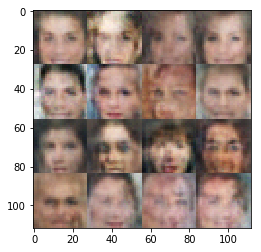

Epoch 1/1... Discriminator Loss: 0.2366... Generator Loss: 7.8256
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 6.8933
Epoch 1/1... Discriminator Loss: 0.1341... Generator Loss: 2.6550
Epoch 1/1... Discriminator Loss: 0.0505... Generator Loss: 4.9460
Epoch 1/1... Discriminator Loss: 0.3563... Generator Loss: 1.3772
Epoch 1/1... Discriminator Loss: 0.1908... Generator Loss: 6.2029
Epoch 1/1... Discriminator Loss: 0.0518... Generator Loss: 6.4443
Epoch 1/1... Discriminator Loss: 0.0280... Generator Loss: 5.6943
Epoch 1/1... Discriminator Loss: 0.1429... Generator Loss: 2.5530
Epoch 1/1... Discriminator Loss: 0.0767... Generator Loss: 5.2302


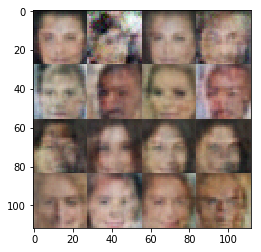

Epoch 1/1... Discriminator Loss: 0.0879... Generator Loss: 3.5171
Epoch 1/1... Discriminator Loss: 0.2294... Generator Loss: 3.3490
Epoch 1/1... Discriminator Loss: 0.0894... Generator Loss: 5.8734
Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 7.0209
Epoch 1/1... Discriminator Loss: 0.0460... Generator Loss: 6.9330
Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 6.2416
Epoch 1/1... Discriminator Loss: 0.0749... Generator Loss: 3.9227
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 0.6727


In [29]:
batch_size = 128
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.